<a href="https://colab.research.google.com/github/han-juyoung/Aimers_Lectures/blob/main/NLP_RNN_%EA%B8%B0%EB%B0%98_%EB%AA%A8%EB%8D%B8%EC%9D%84_%ED%86%B5%ED%95%9C_%ED%9A%8C%EA%B7%80_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

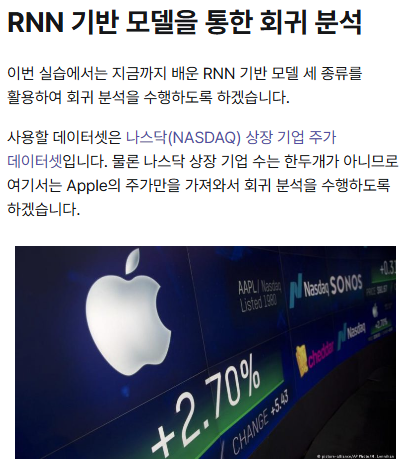

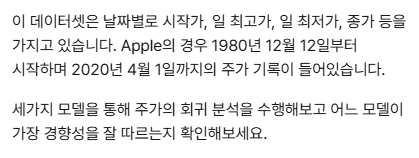

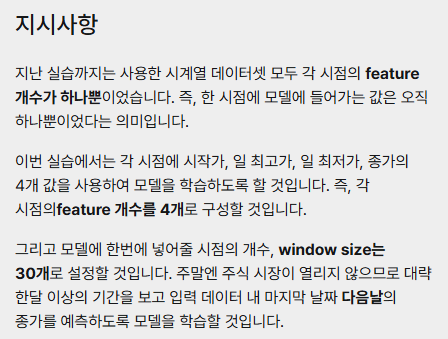

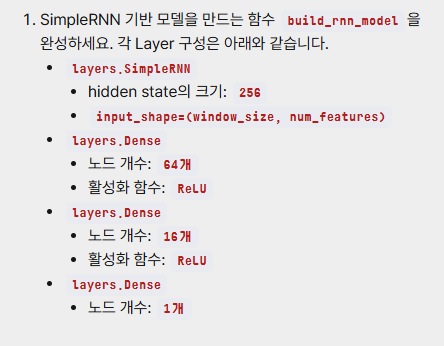

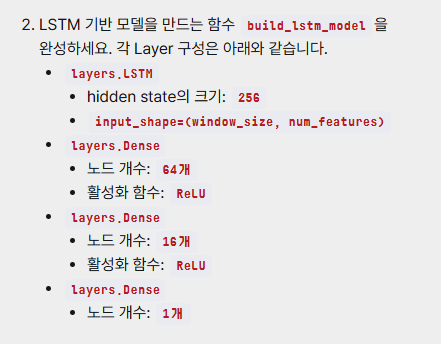

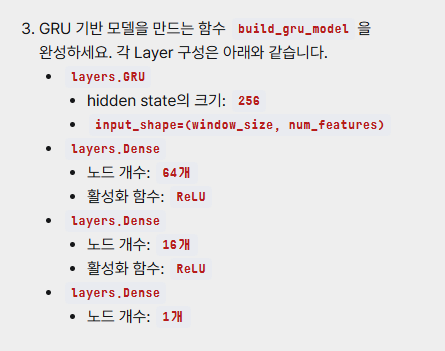

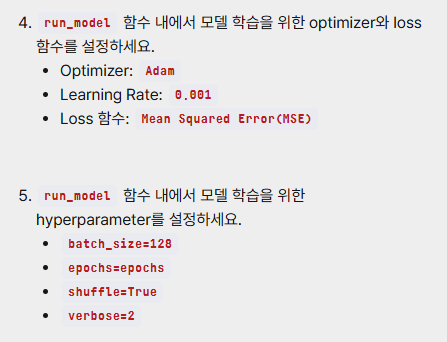

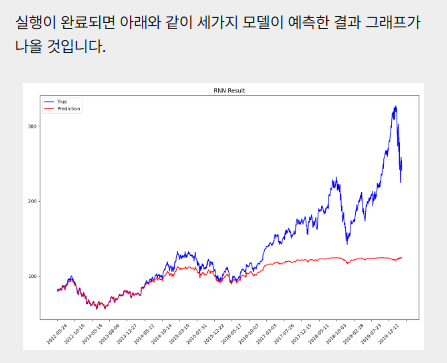

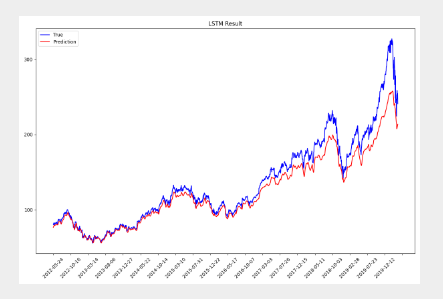

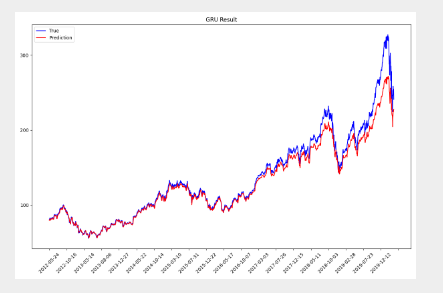

In [ ]:
from elice_utils import EliceUtils

elice_utils = EliceUtils()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def load_data(window_size):
    raw_data_df = pd.read_csv("./AAPL.csv", index_col="Date")

    # 데이터 전체를 표준화합니다.
    scaler = StandardScaler() # 모든 데이터의 평균과 표준편차를 가져와서 표준화해줌
    raw_data = scaler.fit_transform(raw_data_df)
    plot_data = {"mean": scaler.mean_[3], "var": scaler.var_[3], "date": raw_data_df.index}

    # 입력 데이터(X)는 시작가, 일 최고가, 일 최저가, 종가 데이터를 사용하고
    # 라벨 데이터(y)는 4번째 컬럼에 해당하는 종가 데이터만 사용합니다.
    raw_X = raw_data[:, :4]
    raw_y = raw_data[:, 3]

    # window_size 개의 데이터를 불러와 입력 데이터(X)로 설정하고
    # window_size보다 한 시점 뒤의 데이터를 예측할 대상(y)으로 설정하여
    # 데이터셋을 구성합니다.
    X, y = [], []
    for i in range(len(raw_X) - window_size):
        cur_prices = raw_X[i:i + window_size, :]
        target = raw_y[i + window_size]

        X.append(list(cur_prices))
        y.append(target)

    # X와 y를 numpy array로 변환합니다.
    X = np.array(X)
    y = np.array(y)

    # 학습 데이터는 전체 데이터의 80%, 테스트 데이터는 20%로 설정합니다.
    total_len = len(X)
    train_len = int(total_len * 0.8)

    X_train, y_train = X[:train_len], y[:train_len]
    X_test, y_test = X[train_len:], y[train_len:]

    return X_train, X_test, y_train, y_test, plot_data

def build_rnn_model(window_size, num_features):
    model = Sequential()

    # TODO: [지시사항 1번] SimpleRNN 기반 모델을 구성하세요.
    model.add(layers.SimpleRNN(256, input_shape=(window_size, num_features)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1))


    return model

def build_lstm_model(window_size, num_features):
    model = Sequential()

    # TODO: [지시사항 2번] LSTM 기반 모델을 구성하세요.
    model.add(layers.LSTM(256, input_shape=(window_size, num_features)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1))

    return model

def build_gru_model(window_size, num_features):
    model = Sequential()

    # TODO: [지시사항 3번] GRU 기반 모델을 구성하세요.
    model.add(layers.GRU(256, input_shape=(window_size, num_features)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(16, activation="relu"))
    model.add(layers.Dense(1))

    return model

def run_model(model, X_train, X_test, y_train, y_test, epochs=10, name=None):
    # TODO: [지시사항 4번] 모델 학습을 위한 optimizer와 loss 함수를 설정하세요.
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mse")

    # TODO: [지시사항 5번] 모델 학습을 위한 hyperparameter를 설정하세요.
    hist = model.fit(X_train, y_train, epochs=epochs, batch_size=128, shuffle=True, verbose=2)

    # 테스트 데이터셋으로 모델을 테스트합니다.
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print("[{}] 테스트 loss: {:.5f}".format(name, test_loss))
    print()

    return optimizer, hist

def plot_result(model, X_true, y_true, plot_data, name):
    y_pred = model.predict(X_true)

    # 표준화된 결과를 다시 원래 값으로 변환합니다.
    y_true_orig = (y_true * np.sqrt(plot_data["var"])) + plot_data["mean"]
    y_pred_orig = (y_pred * np.sqrt(plot_data["var"])) + plot_data["mean"]

    # 테스트 데이터에서 사용한 날짜들만 가져옵니다.
    test_date = plot_data["date"][-len(y_true):]

    # 모델의 예측값을 실제값과 함께 그래프로 그립니다.
    fig = plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.plot(y_true_orig, color="b", label="True")
    ax.plot(y_pred_orig, color="r", label="Prediction")
    ax.set_xticks(list(range(len(test_date))))
    ax.set_xticklabels(test_date, rotation=45)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.set_title("{} Result".format(name))
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig("apple_stock_{}".format(name.lower()))

    elice_utils.send_image("apple_stock_{}.png".format(name.lower()))

def main():
    tf.random.set_seed(2022)

    window_size = 30
    X_train, X_test, y_train, y_test, plot_data = load_data(window_size)
    num_features = X_train[0].shape[1]

    rnn_model = build_rnn_model(window_size, num_features)
    lstm_model = build_lstm_model(window_size, num_features)
    gru_model = build_gru_model(window_size, num_features)

    run_model(rnn_model, X_train, X_test, y_train, y_test, name="RNN")
    run_model(lstm_model, X_train, X_test, y_train, y_test, name="LSTM")
    run_model(gru_model, X_train, X_test, y_train, y_test, name="GRU")

    plot_result(rnn_model, X_test, y_test, plot_data, name="RNN")
    plot_result(lstm_model, X_test, y_test, plot_data, name="LSTM")
    plot_result(gru_model, X_test, y_test, plot_data, name="GRU")

if __name__ == "__main__":
    main()

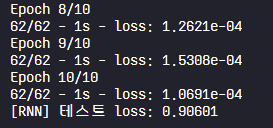

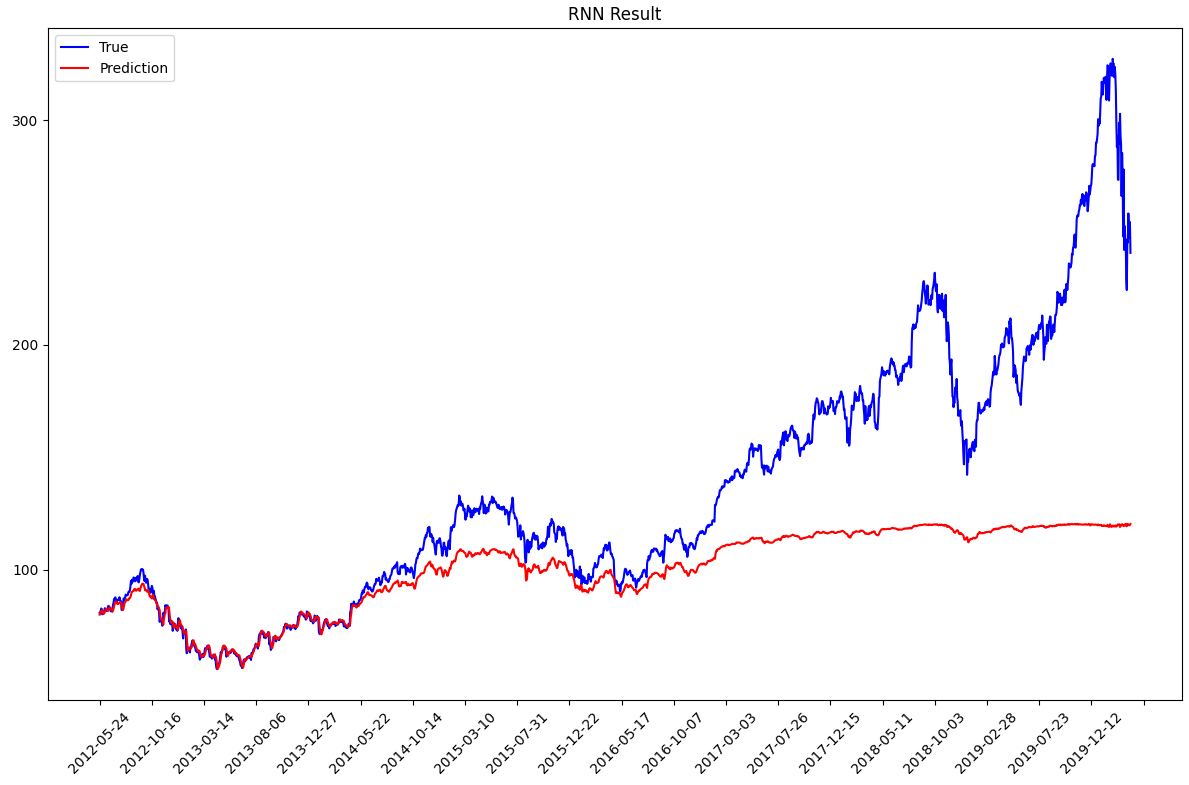

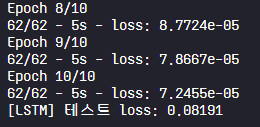

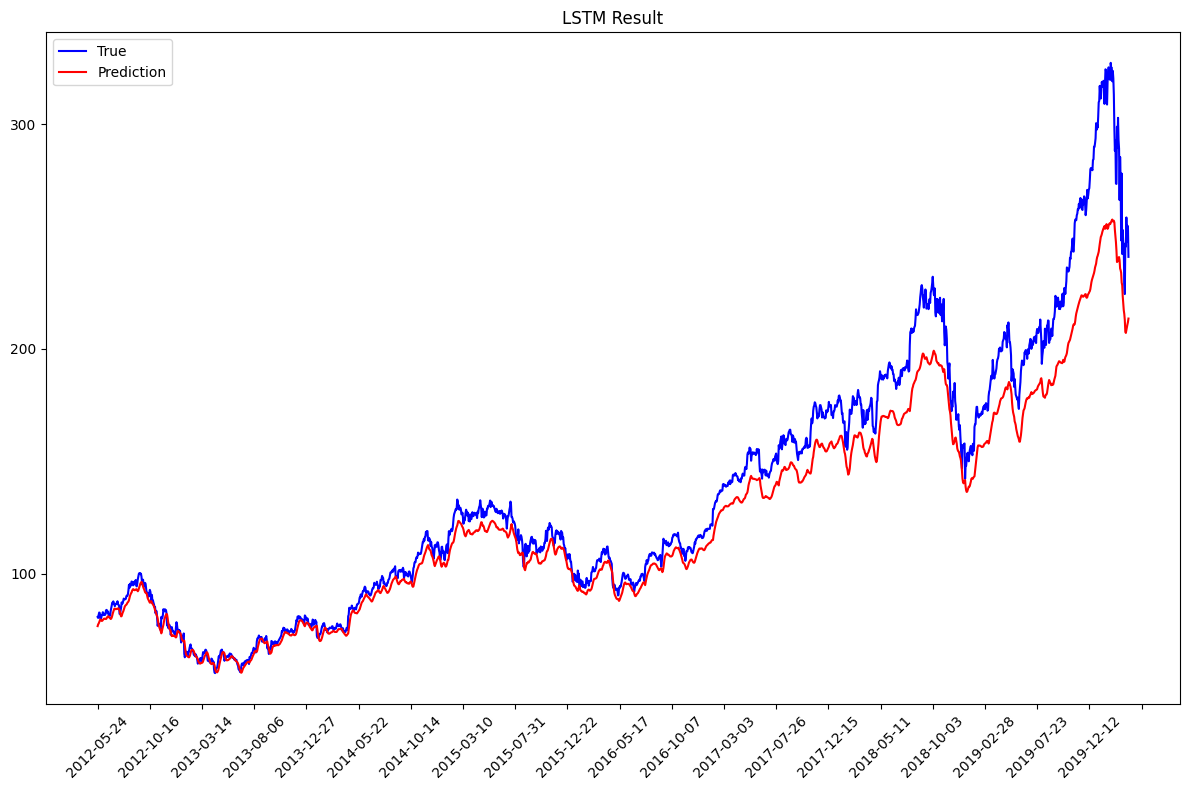

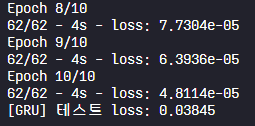

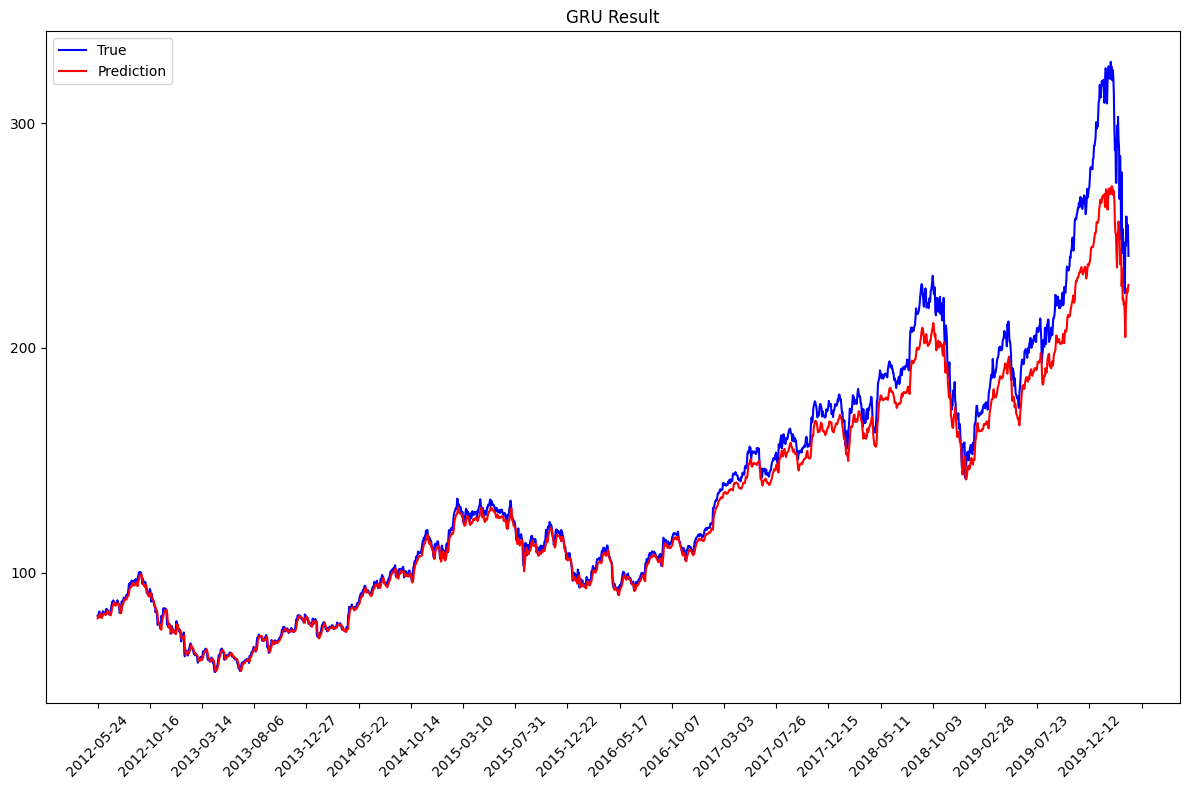

GRU가 가장 예측을 잘 한다.